In [177]:
!pip install earthpy

You should consider upgrading via the '/env/bin/python3 -m pip install --upgrade pip' command.


In [178]:
#import required libraries 
%matplotlib inline
import os 
import numpy as np 
import geopandas as gpd 
import rasterio 
from rasterio.enums import Resampling
from rasterio.plot import show 
import matplotlib.pyplot as plt
import shutil
import xarray as xr
from odc.algo import xr_reproject
from datacube.utils.cog import write_cog
from datacube.utils.geometry import assign_crs
from datacube.testutils.io import rio_slurp_xarray
from odc.algo import xr_reproject
import earthpy.plot as ep
import seaborn as sn
from glob import glob 
import gdal
sn.set()
sn.set_theme(color_codes=True)

In [179]:
#Reading all raster layers as one stacked file and get the mean and s.d of it 
# data_dir = '..//Real_world_examples/LCCSlayer/coherence' # Or sys.argv[1]
# file_list = glob(os.path.join(data_dir, '*.tif'))

# def read_file(file):
#     with rasterio.open(file) as src:
#         return(src.read(1))

# # Read all data as a list of numpy arrays 
# array_list = [read_file(x) for x in file_list]
# # Perform averaging
# array_out1 = np.median(array_list, axis=0)
# array_out2 = np.std(array_list, axis=0)

# # Get metadata from one of the input files
# with rasterio.open(file_list[0]) as src:
#     meta = src.meta
    
# #updating the metadata

# meta.update(dtype=rasterio.float32)

# # Write output file
# with rasterio.open('..//Real_world_examples/LCCSlayer/coherence/median.tif', 'w', **meta) as dst:
#     dst.write(array_out1.astype(rasterio.float32), 1)
# with rasterio.open('..//Real_world_examples/LCCSlayer/coherence/standard_dev.tif', 'w', **meta) as dst:
#     dst.write(array_out2.astype(rasterio.float32), 1)

In [180]:
#Exploring the shape of coherence statistics layer
# coherence_median = xr.open_rasterio('..//Real_world_examples/LCCSlayer/coherence/coh_median.tif')
# coherence_median.shape
# coherence_std = xr.open_rasterio('..//Real_world_examples/LCCSlayer/coherence/coh_std.tif')
# coherence_std.shape

In [181]:
# Read sampling points from shapefile
#pts = gpd.read_file('..//Real_world_examples/LCCSlayer/coherence/samples_250m_landuse.shp')
pts = gpd.read_file('..//Real_world_examples/LCCSlayer/coherence/samples_250m_landuse_QLUMP_2019.shp')

In [182]:
pts.columns

Index(['Join_Count', 'TARGET_FID', 'Id', 'gridcode', 'Value', 'Land_Cover',
       'Red', 'Green', 'Blue', 'XGeometry', 'YGeometry', 'QLD_LC', 'Year',
       'QLUMP_Code', 'ALUM_Code', 'Primary', 'Secondary', 'Tertiary', 'RuleID',
       'geometry'],
      dtype='object')

In [183]:
pts = pts[['XGeometry', 'YGeometry', 'Value', 'Land_Cover','Primary','Secondary','Tertiary','geometry']]

In [184]:
pts.index = range(len(pts))

In [185]:
pts[:20]

,XGeometry,YGeometry,Value,Land_Cover,Primary,Secondary,Tertiary,geometry
0,151.838928,-24.915437,17,Natural Terrestrial Vegetated: Woody Closed (>...,Production from relatively natural environments,Grazing native vegetation,Grazing native vegetation,POINT (151.83893 -24.91544)
1,151.819501,-24.920239,24,Natural Terrestrial Vegetated: Herbaceous Open...,Production from relatively natural environments,Grazing native vegetation,Grazing native vegetation,POINT (151.81950 -24.92024)
2,151.824447,-24.919550,24,Natural Terrestrial Vegetated: Herbaceous Open...,Production from relatively natural environments,Grazing native vegetation,Grazing native vegetation,POINT (151.82445 -24.91955)
3,151.829422,-24.919021,18,Natural Terrestrial Vegetated: Woody Open (40 ...,Production from relatively natural environments,Grazing native vegetation,Grazing native vegetation,POINT (151.82942 -24.91902)
4,151.838485,-24.917380,23,Natural Terrestrial Vegetated: Herbaceous Open...,Production from relatively natural environments,Grazing native vegetation,Grazing native vegetation,POINT (151.83848 -24.91738)
5,151.847092,-24.915276,18,Natural Terrestrial Vegetated: Woody Open (40 ...,Production from relatively natural environments,Grazing native vegetation,Grazing native vegetation,POINT (151.84709 -24.91528)
6,151.838465,-24.920018,18,Natural Terrestrial Vegetated: Woody Open (40 ...,Production from relatively natural environments,Grazing native vegetation,Grazing native vegetation,POINT (151.83847 -24.92002)
7,151.820244,-24.924771,10,Cultivated Terrestrial Vegetated: Herbaceous O...,Production from relatively natural environments,Grazing native vegetation,Grazing native vegetation,POINT (151.82024 -24.92477)
8,151.748954,-24.936994,23,Natural Terrestrial Vegetated: Herbaceous Open...,Production from relatively natural environments,Grazing native vegetation,Grazing native vegetation,POINT (151.74895 -24.93699)
9,151.778580,-24.932831,18,Natural Terrestrial Vegetated: Woody Open (40 ...,Production from relatively natural environments,Grazing native vegetation,Grazing native vegetation,POINT (151.77858 -24.93283)


In [186]:
#Rename the columns in the LCCS table 
pts["Land_Cover"].replace({"Natural Terrestrial Vegetated: Herbaceous Open (15 to 40 %)":"Natural Terrestrial Vegetated(Herbaceous)"}, inplace=True)
pts["Land_Cover"].replace({"Natural Terrestrial Vegetated: Herbaceous Open (40 to 65 %)":"Natural Terrestrial Vegetated(Herbaceous)"}, inplace=True)
pts["Land_Cover"].replace({"Natural Terrestrial Vegetated: Herbaceous Scattered (1 to 4 %)":"Natural Terrestrial Vegetated(Herbaceous)"}, inplace=True)
pts["Land_Cover"].replace({"Natural Terrestrial Vegetated: Herbaceous Sparse (4 to 15 %)":"Natural Terrestrial Vegetated(Herbaceous)"}, inplace=True)
pts["Land_Cover"].replace({"Natural Terrestrial Vegetated: Herbaceous Closed (> 65 %)":"Natural Terrestrial Vegetated(Herbaceous)"}, inplace=True)

pts["Land_Cover"].replace({"Natural Terrestrial Vegetated: Woody Closed (> 65 %)":"Natural Terrestrial Vegetated(Woody)"}, inplace=True)
pts["Land_Cover"].replace({"Natural Terrestrial Vegetated: Woody Open (15 to 40 %)":"Natural Terrestrial Vegetated(Woody)"}, inplace=True)
pts["Land_Cover"].replace({"Natural Terrestrial Vegetated: Woody Open (40 to 65 %)":"Natural Terrestrial Vegetated(Woody)"}, inplace=True)
pts["Land_Cover"].replace({"Natural Terrestrial Vegetated: Woody Scattered (1 to 4 %)":"Natural Terrestrial Vegetated(Woody)"}, inplace=True)
pts["Land_Cover"].replace({"Natural Terrestrial Vegetated: Woody Sparse (4 to 15 %)":"Natural Terrestrial Vegetated(Woody)"}, inplace=True)

pts["Land_Cover"].replace({"Water: (Water) Non-perennial (1 to 3 months)":"Water Non-perennial"}, inplace=True)
pts["Land_Cover"].replace({"Water: (Water) Perennial (> 9 months)":"Water Perennial"}, inplace=True)
pts["Land_Cover"].replace({"Water: (Water) Tidal area":"Water Tidal"}, inplace=True)
pts["Land_Cover"].replace({"Water: (Water) Non-perennial (4 to 6 months)":"Water Non-perennial"}, inplace=True)
pts["Land_Cover"].replace({"Water: (Water) Non-perennial (7 to 9 months)":"Water Non-perennial"}, inplace=True)

pts["Land_Cover"].replace({"Natural Surface: Very sparsely vegetated":"Natural Surface"}, inplace=True)
pts["Land_Cover"].replace({"Natural Surface: Sparsely vegetated":"Natural Surface"}, inplace=True)
pts["Land_Cover"].replace({"Natural Surface: Bare areas, unvegetated":"Natural Surface"}, inplace=True)

pts["Land_Cover"].replace({"Cultivated Terrestrial Vegetated: Woody Sparse (4 to 15 %)":"Cultivated Terrestrial Vegetated(Woody)"}, inplace=True)
pts["Land_Cover"].replace({"Cultivated Terrestrial Vegetated: Woody Scattered (1 to 4 %)":"Cultivated Terrestrial Vegetated(Woody)"}, inplace=True)
pts["Land_Cover"].replace({"Cultivated Terrestrial Vegetated: Woody Open (40 to 65 %)":"Cultivated Terrestrial Vegetated(Woody)"}, inplace=True)
pts["Land_Cover"].replace({"Cultivated Terrestrial Vegetated: Woody Open (15 to 40 %)":"Cultivated Terrestrial Vegetated(Woody)"}, inplace=True)
pts["Land_Cover"].replace({"Cultivated Terrestrial Vegetated: Woody Closed (> 65 %)":"Cultivated Terrestrial Vegetated(Woody)"}, inplace=True)

pts["Land_Cover"].replace({"Cultivated Terrestrial Vegetated: Herbaceous Sparse (4 to 15 %)":"Cultivated Terrestrial Vegetated(Herbaceous)"}, inplace=True)
pts["Land_Cover"].replace({"Cultivated Terrestrial Vegetated: Herbaceous Scattered (1 to 4 %)":"Cultivated Terrestrial Vegetated(Herbaceous)"}, inplace=True)
pts["Land_Cover"].replace({"Cultivated Terrestrial Vegetated: Herbaceous Open (40 to 65 %)":"Cultivated Terrestrial Vegetated(Herbaceous)"}, inplace=True)
pts["Land_Cover"].replace({"Cultivated Terrestrial Vegetated: Herbaceous Open (15 to 40 %)":"Cultivated Terrestrial Vegetated(Herbaceous)"}, inplace=True)
pts["Land_Cover"].replace({"Cultivated Terrestrial Vegetated: Herbaceous Closed (> 65 %)":"Cultivated Terrestrial Vegetated(Herbaceous)"}, inplace=True)

In [187]:
pts["Land_Cover"].replace({"Natural Terrestrial Vegetated(Woody)":"Natural Vegetation"}, inplace=True)
pts["Land_Cover"].replace({"Natural Terrestrial Vegetated(Herbaceous)":"Natural Vegetation"}, inplace=True)
pts["Land_Cover"].replace({"Cultivated Terrestrial Vegetated(Herbaceous)":"Cultivated Vegetation"}, inplace=True)
pts["Land_Cover"].replace({"Cultivated Terrestrial Vegetated(Woody)":"Cultivated Vegetation"}, inplace=True)
pts["Land_Cover"].replace({"Water Non-perennial":"Water","Water Perennial":"Water"}, inplace=True)

In [188]:
pts

,XGeometry,YGeometry,Value,Land_Cover,Primary,Secondary,Tertiary,geometry
0,151.838928,-24.915437,17,Natural Vegetation,Production from relatively natural environments,Grazing native vegetation,Grazing native vegetation,POINT (151.83893 -24.91544)
1,151.819501,-24.920239,24,Natural Vegetation,Production from relatively natural environments,Grazing native vegetation,Grazing native vegetation,POINT (151.81950 -24.92024)
2,151.824447,-24.919550,24,Natural Vegetation,Production from relatively natural environments,Grazing native vegetation,Grazing native vegetation,POINT (151.82445 -24.91955)
3,151.829422,-24.919021,18,Natural Vegetation,Production from relatively natural environments,Grazing native vegetation,Grazing native vegetation,POINT (151.82942 -24.91902)
4,151.838485,-24.917380,23,Natural Vegetation,Production from relatively natural environments,Grazing native vegetation,Grazing native vegetation,POINT (151.83848 -24.91738)
...,...,...,...,...,...,...,...,...
114363,150.390731,-28.799205,18,Natural Vegetation,None,None,None,POINT (150.39073 -28.79920)
114364,150.396980,-28.795945,25,Natural Vegetation,None,None,None,POINT (150.39698 -28.79594)
114365,150.401951,-28.793741,24,Natural Vegetation,None,None,None,POINT (150.40195 -28.79374)
114366,150.406337,-28.792577,11,Cultivated Vegetation,None,None,None,POINT (150.40634 -28.79258)


In [189]:
coords = [(x,y) for x, y in zip(pts.XGeometry, pts.YGeometry)]

In [190]:
# Open the coherence mean raster file and store metadata
coh_median = rasterio.open('..//Real_world_examples/LCCSlayer/coherence/coh_median.tif')

In [191]:
coh_mean = rasterio.open('..//Real_world_examples/LCCSlayer/coherence/coh_mean.tif')

In [192]:
# Sample the mean layer at every point location and store values in DataFrame
pts['Median of Coherence'] = [x for x in coh_median.sample(coords)]
pts['Median of Coherence'] = pts.apply(lambda x: x['Median of Coherence'][0], axis=1)

In [193]:
# Open the coherence SD raster file and store metadata
coh_std = rasterio.open('..//Real_world_examples/LCCSlayer/coherence/coh_std.tif')

In [194]:
# Sample the std layer at every point location and store values in DataFrame
pts['Standard Deviation of Coherence'] = [x for x in coh_std.sample(coords)]
pts['Standard Deviation of Coherence'] = pts.apply(lambda x: x['Standard Deviation of Coherence'][0], axis=1)

In [195]:
pts['Mean of Coherence'] = [x for x in coh_mean.sample(coords)]
pts['Mean of Coherence'] = pts.apply(lambda x: x['Mean of Coherence'][0], axis=1)

In [196]:
pts

,XGeometry,YGeometry,Value,Land_Cover,Primary,Secondary,Tertiary,geometry,Median of Coherence,Standard Deviation of Coherence,Mean of Coherence
0,151.838928,-24.915437,17,Natural Vegetation,Production from relatively natural environments,Grazing native vegetation,Grazing native vegetation,POINT (151.83893 -24.91544),0.187238,0.113947,0.183304
1,151.819501,-24.920239,24,Natural Vegetation,Production from relatively natural environments,Grazing native vegetation,Grazing native vegetation,POINT (151.81950 -24.92024),0.240032,0.181511,0.259874
2,151.824447,-24.919550,24,Natural Vegetation,Production from relatively natural environments,Grazing native vegetation,Grazing native vegetation,POINT (151.82445 -24.91955),0.221618,0.159756,0.231249
3,151.829422,-24.919021,18,Natural Vegetation,Production from relatively natural environments,Grazing native vegetation,Grazing native vegetation,POINT (151.82942 -24.91902),0.166817,0.094377,0.158654
4,151.838485,-24.917380,23,Natural Vegetation,Production from relatively natural environments,Grazing native vegetation,Grazing native vegetation,POINT (151.83848 -24.91738),0.187238,0.113947,0.183304
...,...,...,...,...,...,...,...,...,...,...,...
114363,150.390731,-28.799205,18,Natural Vegetation,None,None,None,POINT (150.39073 -28.79920),0.160945,0.079544,0.165711
114364,150.396980,-28.795945,25,Natural Vegetation,None,None,None,POINT (150.39698 -28.79594),0.310512,0.189569,0.345608
114365,150.401951,-28.793741,24,Natural Vegetation,None,None,None,POINT (150.40195 -28.79374),0.436490,0.152244,0.431321
114366,150.406337,-28.792577,11,Cultivated Vegetation,None,None,None,POINT (150.40634 -28.79258),0.418491,0.181307,0.420946


In [197]:
#Get the geometry of the points 
from shapely.geometry import Point
from geopandas import GeoSeries, GeoDataFrame
geometry = [Point(xy) for xy in zip(pts.XGeometry, pts.YGeometry)]
crs = {'init': 'epsg:4326'} 
samplepoints = GeoDataFrame(pts, crs=crs, geometry=geometry)

/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [198]:
AOI = '..//Real_world_examples/LCCSlayer/coherence/AOI_Assessment.shp'

In [199]:
outline = gpd.read_file(AOI).to_crs('EPSG:4326')
outline

,Id,geometry
0,0,"POLYGON ((150.09506 -25.87995, 152.05659 -25.8..."


In [200]:
Zone_points = gpd.clip(samplepoints, outline)

/env/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:4326

  """Entry point for launching an IPython kernel.


In [201]:
Zone_points.count()

XGeometry                          59266
YGeometry                          59266
Value                              59266
Land_Cover                         59266
Primary                            59266
Secondary                          59266
Tertiary                           59266
geometry                           59266
Median of Coherence                59266
Standard Deviation of Coherence    59266
Mean of Coherence                  59266
dtype: int64

In [202]:
#pts_random_50pc = pts.sample(frac=0.5, replace=True, random_state=1)
#pts_selected = pts[5000:10000]
#pts_selected = pts_selected.rename(columns={'Coh_mean':'Mean of Coherence','Coh_SD':'Standad Deviation of Coherence'})

In [203]:
NatVeg = Zone_points[Zone_points["Land_Cover"] == 'Natural Vegetation']
CultVeg = Zone_points[Zone_points["Land_Cover"] == 'Cultivated Vegetation']
Water =  Zone_points[Zone_points["Land_Cover"] == 'Water']
NatSurf = Zone_points[Zone_points["Land_Cover"] == 'Natural Surface']
ArtSurf = Zone_points[Zone_points["Land_Cover"] == 'Artificial Surface']

In [204]:
palette ={"Natural Vegetation": "green", "Cultivated Vegetation": "orange", "Water": "blue", "Natural Surface": "red","Artificial Surface":"cyan"}

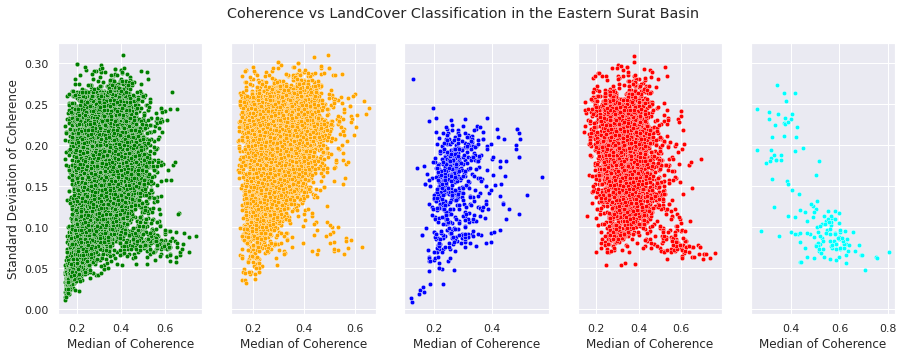

In [205]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5), sharey=True)
fig.suptitle('Coherence vs LandCover Classification in the Eastern Surat Basin')
sn.scatterplot(ax =axes[0],x="Median of Coherence", y="Standard Deviation of Coherence", color ="green", data=NatVeg,s=20)
sn.scatterplot(ax =axes[1],x="Median of Coherence", y="Standard Deviation of Coherence", color ="orange", data=CultVeg,s=20)
sn.scatterplot(ax =axes[2],x="Median of Coherence", y="Standard Deviation of Coherence", color ="blue",data=Water,s=20)
sn.scatterplot(ax =axes[3],x="Median of Coherence", y="Standard Deviation of Coherence", color="red", data=NatSurf,s=20)
sn.scatterplot(ax =axes[4],x="Median of Coherence", y="Standard Deviation of Coherence", color="cyan", data=ArtSurf,s=20)

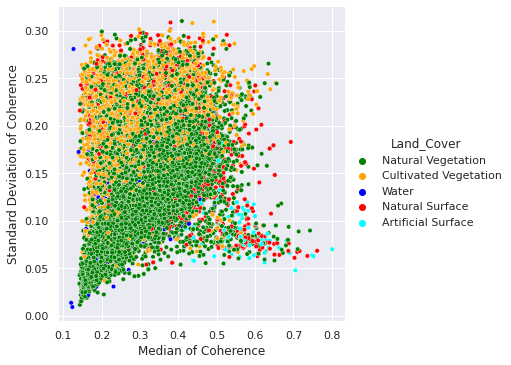

In [206]:
sn.relplot(x="Median of Coherence", y="Standard Deviation of Coherence", hue="Land_Cover",sizes=(4, 4), data=Zone_points,s=20, palette=palette);

In [207]:
Zone_points["Tertiary"].replace({"Aquaculture":"Water","Marsh/wetland":"Water","Marsh/wetland - conservation":"Water","Marsh/wetland - production":"Water","Water extraction and transmission":"Water","Water storage - intensive use/farm dams":"Water","Sewage":"Water","River":"Water","Lake - conservation":"Water","Lake":"Water","Effluent pond":"Water"}, inplace=True)
Zone_points["Tertiary"].replace({"Irrigated cereals":"Irrigated land","Irrigated citrus":"Irrigated land","Irrigated cotton":"Irrigated land","Irrigated cropping":"Irrigated land","Irrigated grapes":"Irrigated land","Irrigated hay and silage":"Irrigated land","Irrigated oilseeds":"Irrigated land","Irrigated olives":"Irrigated land","Irrigated perennial horticulture":"Irrigated land","Irrigated seasonal fruits":"Irrigated land","Irrigated seasonal horticulture":"Irrigated land","Irrigated seasonal vegetables and herbs":"Irrigated land",
                                "Irrigated shrub berries and fruits":"Irrigated land","Irrigated sugar":"Irrigated land","Irrigated tree fruits":"Irrigated land","Irrigated turf farming":"Irrigated land","Irrigated vine fruits":"Irrigated land","Irrigated woody fodder plants":"Irrigated land","Degraded irrigated land":"Irrigated land"}, inplace=True)
Zone_points["Tertiary"].replace({"Land in transition":"Abondoned Land","Abandoned manufacturing and industrial":"Abondoned Land","Abandoned land":"Abondoned Land","Abandoned perennial horticulture":"Abondoned Land","Extractive industry not in use":"Abondoned Land"}, inplace=True)
Zone_points["Tertiary"].replace({"Rural":"Residential","Remote communities":"Residential","Urban residential":"Residential","Rural residential without agriculture":"Residential","Rural residential with agriculture":"Residential","Rural residential with agriculture":"Residential","Rural residential without agriculture":"Residential"}, inplace=True)
Zone_points["Tertiary"].replace({"Recreation and culture":"Infrastructure","Reservoir/dam":"Infrastructure","Saleyards/stockyards":"Infrastructure","Horse studs":"Infrastructure","Poultry farms":"Infrastructure","Services":"Infrastructure","Manufacturing and industrial":"Infrastructure","Public services":"Infrastructure","Research facilities":"Infrastructure","Residential and farm infrastructure":"Infrastructure","Navigation and communication":"Infrastructure","Abattoirs":"Infrastructure","Rehabilitation":"Infrastructure","Roads":"Infrastructure","Transport and communication":"Infrastructure","Airports/aerodromes":"Infrastructure","Bulk grain storage":"Infrastructure","Channel/aqueduct":"Infrastructure", "Commercial services":"Infrastructure","Dairy sheds and yards":"Infrastructure","Defence":"Infrastructure","Defence facilities - urban":"Infrastructure","Electricity substations and transmission":"Infrastructure","Farm buildings/infrastructure":"Infrastructure","Feedlots":"Infrastructure","Food processing factory":"Infrastructure","Fuel powered electricity generation":"Infrastructure",
                                "Gas treatment, storage and transmission":"Infrastructure","Shadehouses":"Infrastructure","Sawmill":"Infrastructure","Railways":"Infrastructure"}, inplace=True)
Zone_points["Tertiary"].replace({"Hay and silage":"Crops","Perennial horticulture":"Crops","Cereals":"Crops","Cotton":"Crops","Cropping":"Crops","Intensive horticulture":"Crops","Vine fruits":"Crops","Intensive horticulture":"Crops","Tree nuts":"Crops","Tree fruits":"Crops","Shrub berries and fruits":"Crops","Olives":"Crops","Oilseeds":"Crops"},inplace=True)
Zone_points["Tertiary"].replace({"Grazing irrigated modified pastures":"Grazing","Grazing modified pastures":"Grazing","Grazing native vegetation":"Grazing","Intensive animal production":"Grazing","Piggeries":"Grazing"}, inplace=True)
Zone_points["Tertiary"].replace({"Managed resource protection":"Other","Evaporation basin":"Other","Habitat/species management area":"Other","Other conserved area":"Other","Other minimal use":"Other"}, inplace=True)
Zone_points["Tertiary"].replace({"Plantation forests":"Forestry","Hardwood plantation forestry":"Forestry","Woody fodder plants":"Forestry","Softwood plantation forestry":"Forestry","Production native forests":"Forestry"}, inplace=True)
Zone_points["Tertiary"].replace({"Tailings":"Mining","Quarries":"Mining","Mines":"Mining","Reservoir":"Mining"},inplace=True)
Zone_points["Tertiary"].replace({"Landfill":"Landfill","Waste treatment and disposal":"Landfill","Solid garbage":"Landfill"},inplace=True)
Zone_points["Tertiary"].replace({"National park":"Natural Vegetation","Residual native cover":"Natural Vegetation","Natural feature protection":"Natural Vegetation"},inplace=True)


In [237]:
palette ={"Natural Vegetation": "green","Crops":"lightseagreen","Forestry":"forestgreen", "Mining": "orange", "Grazing":"darkgoldenrod","Water": "blue", "Irrigated land":"yellowgreen","Abondoned Land":"Gray","Residential":"yellow","Infrastructure":"darkslategray","Landfill":"slateblue","Other":"cyan"}

In [238]:
sn.color_palette()

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.8, 0.7254901960784313, 0.4549019607843137),
 (0.39215686274509803, 0.7098039215686275, 0.803921568627451)]

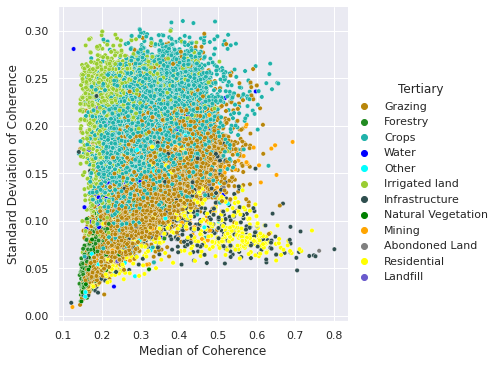

In [239]:
sn.relplot(x="Median of Coherence", y="Standard Deviation of Coherence", hue="Tertiary",sizes=(4, 4), data=Zone_points,s=20,palette=palette);

In [241]:
Grazing = Zone_points[Zone_points["Tertiary"] == 'Grazing']
Forest = Zone_points[Zone_points["Tertiary"] == 'Forestry']
Crops =  Zone_points[Zone_points["Tertiary"] == 'Crops']
Water = Zone_points[Zone_points["Tertiary"] == 'Water']
Irrigatedland = Zone_points[Zone_points["Tertiary"] == 'Irrigated land']


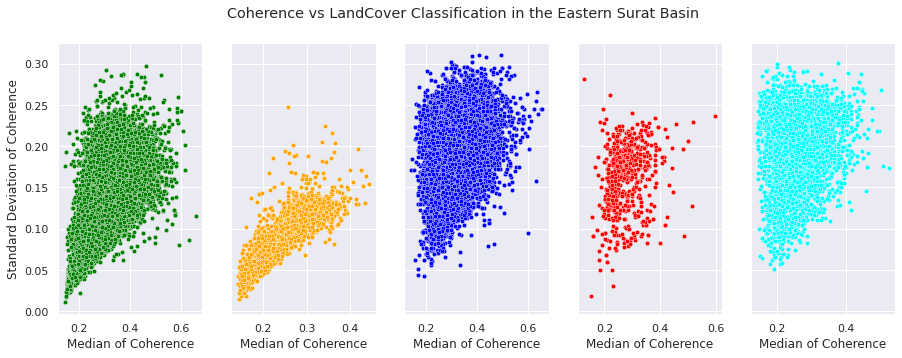

In [242]:
#revise the colors 
fig, axes = plt.subplots(1, 5, figsize=(15, 5), sharey=True)
fig.suptitle('Coherence vs LandCover Classification in the Eastern Surat Basin')
sn.scatterplot(ax =axes[0],x="Median of Coherence", y="Standard Deviation of Coherence", color ="green", data=Grazing,s=20)
sn.scatterplot(ax =axes[1],x="Median of Coherence", y="Standard Deviation of Coherence", color ="orange", data=Forest,s=20)
sn.scatterplot(ax =axes[2],x="Median of Coherence", y="Standard Deviation of Coherence", color ="blue",data=Crops,s=20)
sn.scatterplot(ax =axes[3],x="Median of Coherence", y="Standard Deviation of Coherence", color="red", data=Water,s=20)
sn.scatterplot(ax =axes[4],x="Median of Coherence", y="Standard Deviation of Coherence", color="cyan", data=Irrigatedland,s=20)

In [158]:
Zone_points.columns

Index(['XGeometry', 'YGeometry', 'Value', 'Land_Cover', 'Primary', 'Secondary',
       'Tertiary', 'geometry', 'Median of Coherence',
       'Standard Deviation of Coherence', 'Mean of Coherence'],
      dtype='object')

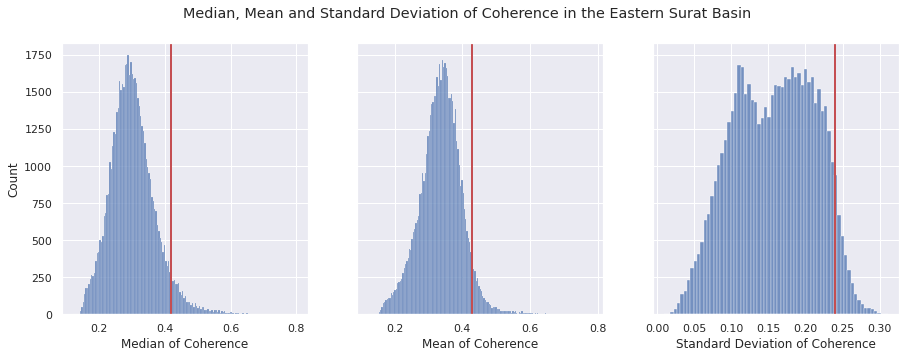

In [121]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle('Median, Mean and Standard Deviation of Coherence in the Eastern Surat Basin')
sn.histplot(ax =axes[0],x=Zone_points["Median of Coherence"])
axes[0].axvline(x=.42,linewidth=2, color='r')
sn.histplot(ax =axes[1],x=Zone_points["Mean of Coherence"])
axes[1].axvline(x=.43,linewidth=2, color='r')
sn.histplot(ax =axes[2],x=Zone_points["Standard Deviation of Coherence"])
axes[2].axvline(x=.24,linewidth=2, color='r')

In [122]:
NewPts=Zone_points.rename(columns={"Median of Coherence": "Median", "Standard Deviation of Coherence": "STD","Mean of Coherence":"Mean"})

In [118]:
NewPts[['Median','STD','Mean']].dropna().quantile([0.0, .5, .90, .95])

,Median,STD,Mean
0.00,0.120853,0.009050,0.122567
0.50,0.297112,0.160183,0.338450
0.90,0.389495,0.228973,0.408695
0.95,0.424483,0.240914,0.431721


In [25]:
#window reading of an image 
from rasterio.windows import Window
from rasterio.windows import get_data_window

with rasterio.open('..//Real_world_examples/LCCSlayer/coherence/median.tif') as src:
    window =  get_data_window(src.read(1, masked=True))
    kwargs = src.meta.copy()
    kwargs.update({
        'height': window.height,
        'width': window.width,
        'transform': rasterio.windows.transform(window, src.transform)})
    with rasterio.open('..//Real_world_examples/LCCSlayer/coherence/ccc.tif','w', **kwargs) as dst:
        dst.write(src.read(window=window))

In [37]:
# raster = gdal.Open(r'..//Real_world_examples/LCCSlayer/coherence/stack.tif')
# bands = raster.RasterCount

# for band in range(1, bands+1):
#     data = raster.GetRasterBand(band).ReadAsArray().astype('float')
#     mean = np.mean(data[data != 0]) #calculate mean without value 0
#     print("Band %s: Mean = %s" % (band, round(mean, 2)))

In [16]:
# Load raster and reproject to match satellite InSAR
# LCCS_reprojected = rio_slurp_xarray(fname='..//Real_world_examples/LCCSlayer/lccs_2015_250m.tif',
#                                       gbox=InSAR.geobox,
#                                       resampling="mode")

In [17]:
print(LCCS_reprojected) #this layer needs to be devided by 1.7 scaling factor if we use the other approach

<xarray.DataArray (latitude: 965, longitude: 832)>
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
Coordinates:
  * latitude     (latitude) float64 -24.79 -24.8 -24.8 ... -28.8 -28.8 -28.81
  * longitude    (longitude) float64 149.4 149.4 149.4 ... 152.9 152.9 152.9
    spatial_ref  int32 4326
Attributes:
    nodata:   0.0


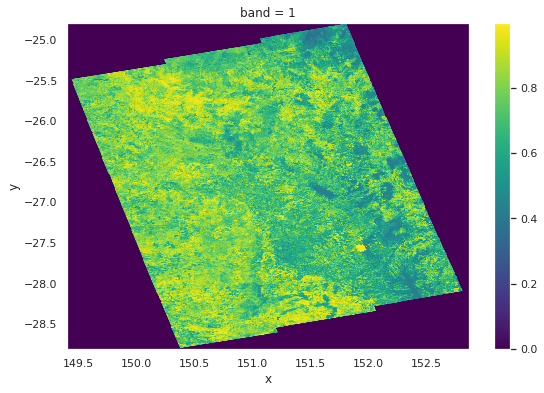

In [17]:
coherence_mean.plot(size=6)

In [20]:
InSAR_no_zeros = InSAR.where(InSAR != 0, np.nan)

In [2]:
InSAR_filt = assign_crs(xr.open_rasterio('..//Real_world_examples/LCCSlayer/coherence/20160324-20160417_HH_8rlks_filt_eqa_cc.tif'))
InSAR_flat = assign_crs(xr.open_rasterio('..//Real_world_examples/LCCSlayer/coherence/20160324-20160417_HH_8rlks_flat_eqa_cc.tif'))

/env/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


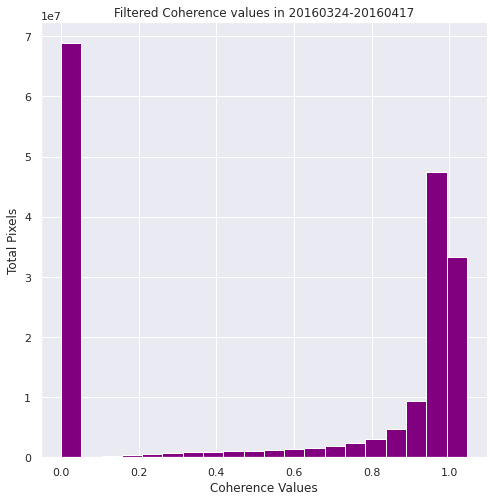

In [7]:
ax = ep.hist(InSAR_filt.values,
             figsize=(8, 8),
             colors="purple",
             xlabel="Coherence Values",
             ylabel="Total Pixels",
             title="Filtered Coherence values in 20160324-20160417")

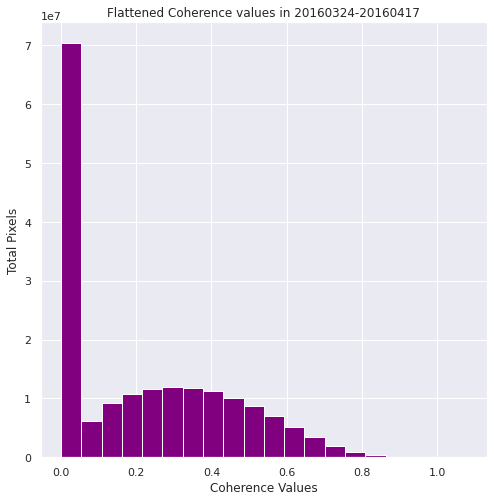

In [8]:
ax = ep.hist(InSAR_flat.values,
             figsize=(8, 8),
             colors="purple",
             xlabel="Coherence Values",
             ylabel="Total Pixels",
             title="Flattened Coherence values in 20160324-20160417")

In [7]:
CohM_SB = assign_crs(xr.open_rasterio('..//Real_world_examples/LCCSlayer/coherence/COH_MEDIAN.tif'))
CohM_NM = assign_crs(xr.open_rasterio('..//Real_world_examples/LCCSlayer/coherence/median.tif'))

/env/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


In [34]:
CohM_NM.shape

(1, 72, 47)

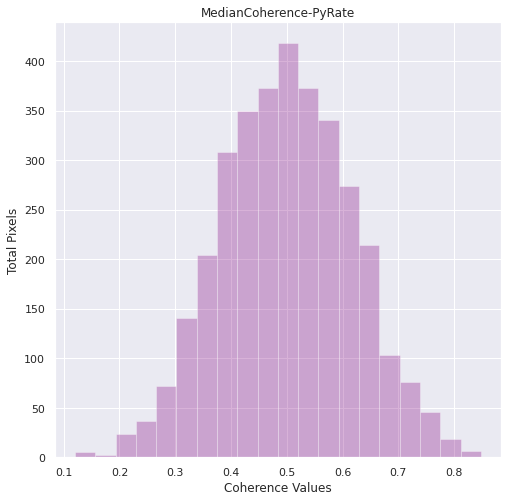

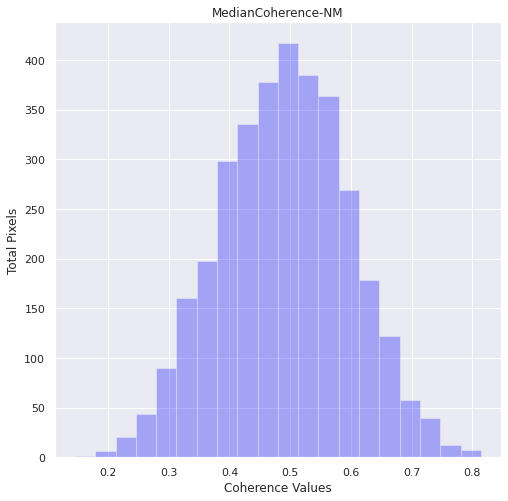

In [52]:
ax1 = ep.hist(CohM_SB.values,
             figsize=(8, 8),alpha=0.3,
             colors="purple",
             xlabel="Coherence Values",
             ylabel="Total Pixels",
             title="MedianCoherence-PyRate")

ax2 = ep.hist(CohM_NM.values,
             figsize=(8, 8),alpha=0.3,
             colors="blue",
             xlabel="Coherence Values",
             ylabel="Total Pixels",
             title="MedianCoherence-NM")

In [ ]:
CohSD_SB = assign_crs(xr.open_rasterio('..//Real_world_examples/LCCSlayer/coherence/COH_STD.tif'))
CohSD_NM = assign_crs(xr.open_rasterio('..//Real_world_examples/LCCSlayer/coherence/standard_dev.tif'))

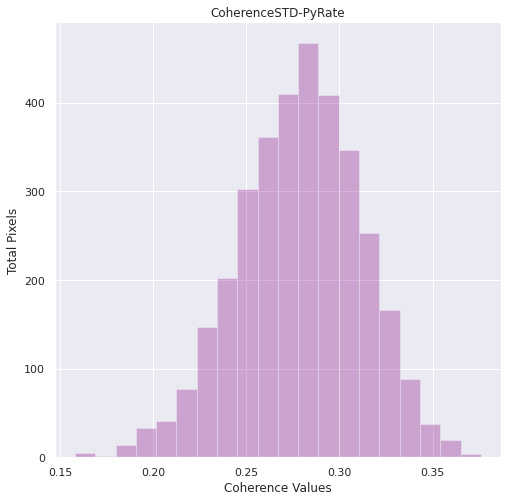

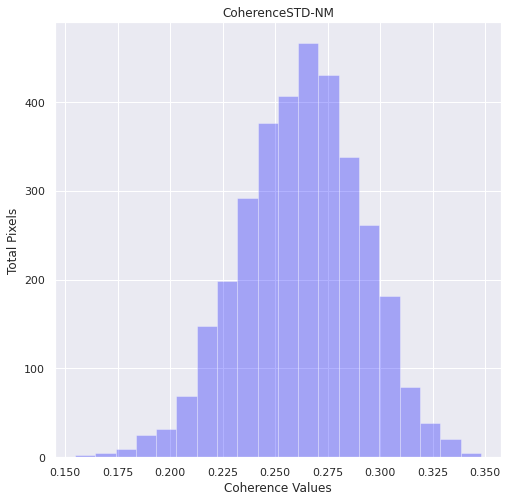

In [57]:
ax1 = ep.hist(CohSD_SB.values,
             figsize=(8, 8),alpha=0.3,
             colors="purple",
             xlabel="Coherence Values",
             ylabel="Total Pixels",
             title="CoherenceSTD-PyRate")

ax2 = ep.hist(CohSD_NM.values,
             figsize=(8, 8),alpha=0.3,
             colors="blue",
             xlabel="Coherence Values",
             ylabel="Total Pixels",
             title="CoherenceSTD-NM")

In [28]:
#using multiple coherence files and generate a stack
coh_list = ['..//Real_world_examples/LCCSlayer/20151219-20160112_coh.tif','..//Real_world_examples/LCCSlayer/20151219-20160205_coh.tif','..//Real_world_examples/LCCSlayer/20160112-20160205_coh.tif']
#read the metadata from the first file 
with rasterio.open(coh_list[0]) as src0:
    meta = src0.meta
#update meta to reflect the number of raster files
meta.update(count = len(coh_list))
#Read each layer and write it to the stack
with rasterio.open('..//Real_world_examples/LCCSlayer/stack.tif','w',**meta) as dst:
    for id, layer in enumerate(coh_list,start=1):
        with rasterio.open(layer) as src1:
            dst.write_band(id,src1.read(1))

In [37]:
coherence.shape

(3, 965, 832)

In [ ]:
#generate coherence mean and standard deviation 



In [ ]:
#there is a shapefile that you can load and then do the sampling based on the points 
- read the shapefile with points 
- sample the coherence value on each point 

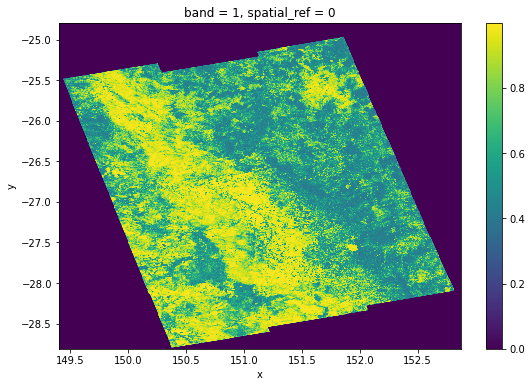

In [6]:
InSAR.plot(size=6)

In [ ]:
#View the data we're using
plt.figure(figsize = (8, 8))
plt.axis("off")
img = plt.imshow(data_array, cmap = "viridis")

In [26]:
write_cog(geo_im=LCCS_reprojected,
          fname='..//Real_world_examples/LCCSlayer/lccs_2015_450m.tif',
          overwrite=True)

PosixPath('../Real_world_examples/LCCSlayer/lccs_2015_450m.tif')

In [22]:
InSAR.geobox #width, height in pixel, Affine with spatial resolution and spatial position, and coordinate reference system 

GeoBox(832, 965, Affine(0.004166666700000004, 0.0, 149.40430581111,
       0.0, -0.004166666699999998, -24.79013911111), GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]])

In [24]:
InSAR.geobox.resolution   #InSAR.geobox.extent.boundingbox

(-0.004166666699999998, 0.004166666700000004)

In [26]:
LCCS_coarse = xr_reproject(src=LCCS,
                          geobox=InSAR.geobox,
                          resampling='mode')

In [ ]:
write_cog(LCCS_coarse)

In [51]:
#open the source file and grab metadata from original file 
with rasterio.open('..//Real_world_examples/LCCSlayer/lccs_2015_250m.tif') as src:
    metadata = src.profile
metadata['dtype'] = 'uint8'
metadata['transform'] = src.transform

In [53]:
downscale_factor = 10

In [54]:
#resample LCCS raster file to higher resolution 
with rasterio.open('..//Real_world_examples/LCCSlayer/lccs_2015_250m.tif') as dataset:
        #resample data to target shape
    data = dataset.read(out_shape=(dataset.count,
                                   int(dataset.height*downscale_factor),
                                   int(dataset.width*downscale_factor)),
                        resampling=Resampling.bilinear
    )
    #scale image transform
    transform = dataset.transform * dataset.transform.scale(
        (dataset.width / data.shape[-1]),
        (dataset.height / data.shape[-2])
    )
#     transform[:6]
    metadata['transform'] = tuple(transform[:6])
#     print(tuple(transform))


In [55]:
metadata

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': 0.0, 'width': 1148, 'height': 1643, 'count': 1, 'crs': CRS.from_epsg(3577), 'transform': (25.0, 0.0, 1727000.0, 0.0, -25.0, -2846250.0), 'tiled': False, 'interleave': 'band'}

In [13]:
#a numpy array
print(data.shape)

(1, 2957, 2066)


In [56]:
with rasterio.open('..//Real_world_examples/LCCSlayer/lccs-new2.tif','w',**metadata) as dst:
    dst.write(data)

In [175]:
#a numpy array
print(data.shape)

(1, 6572, 4592)


In [122]:
{i: dtype for i, dtype in zip(dataset.indexes, dataset.dtypes)}

{1: 'uint8'}

In [ ]:
#import shapefile of the points that are going to be sampled
#by plotting the point data crs and also your raster make sure that both are in the same coordinate system 
pointData = gpd.read_file('path to the shapefile')
print(pointData.crs)
pointData.plot();

In [ ]:
#Read and open the raster file that needs to be resampled 
#Land cover and Land use file 
LCCRaster = rasterio.open('path to the LCCS file')
print(LCCRaster.crs)
print(LCCRaster.count)
#InSAR coherence file 
# CohRaster = rasterio.open('path to the coherence file')
# print(CohRaster.crs)
# print(CohRaster.count)

In [ ]:
#showing both points and raster file in one plot 
fig, ax = plt.subplot(figsize=(12,12))
pointData.plot(ax=ax, color = 'orangered')
show(LCCRaster,ax=ax)

In [ ]:
#extract point geometry from the point shapefile
for point in pointData['geometry']:
    print(point.xy[0][0],point.xy[1][0])

In [ ]:
#extract raster values in each point location 
for point in pointData['geometry']:
    x = point.xy[0][0]
    y = point.xy[1][0]
    row,col = LCCRaster.index(x,y)
    print('Point corresponds to row,column: %d,%d'%(row,col))
    print('Raster value on point  %.2f \n'%(LCCRaster.read(1)[row,col])) #for single band raster 

In [ ]:
#the reference is here: https://www.youtube.com/watch?v=QhUcgOOsUy8